# PISA 2018

TODO:
- napočítej výsledky podle krajů pro čtenářskou gramotnost
- zkontroluj, že to odpovídá výsledkům podle ČŠI
- zkus z toho udělat nějaké kartogramy, i pro ostatní gramotnosti
- napočítej přísnost podle krajů a podívej se, co z toho vychází

In [50]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

In [4]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [5]:
sch18, sch18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_SCH_QQQ_FINAL_CZ.sav')
stu18, stu18_meta = pyreadstat.read_sav(f'{data_root}/PISA/2018/CZ/CY07_MSU_STU_QQQ_FINAL_CZ.sav')

In [9]:
stu18.head().T.to_csv('temp/stu18.csv')

In [160]:
stu18.groupby('ST001D01T')['CNTSTUID'].count()

ST001D01T
7.0       25
8.0      142
9.0     2920
10.0    3932
Name: CNTSTUID, dtype: int64

In [170]:
stu18.groupby('ST003D03T')['CNTSTUID'].count()

ST003D03T
2002.0    7019
Name: CNTSTUID, dtype: int64

In [214]:
stu18.groupby('ST004D01T')['CNTSTUID'].count()

ST004D01T
1.0    3518
2.0    3501
Name: CNTSTUID, dtype: int64

In [252]:
sch18.head()

CNTRYID    CNTSCHID  SC001Q01TA  SC013Q01TA  SC016Q01TA  SC016Q02TA  \
0    203.0  20300001.0         3.0         1.0        97.0         1.0   
1    203.0  20300002.0         3.0         1.0       100.0         0.0   
2    203.0  20300003.0         3.0         1.0       100.0         0.0   
3    203.0  20300004.0         3.0         1.0       100.0         0.0   
4    203.0  20300005.0         2.0         1.0         NaN         NaN   

   SC016Q03TA  SC016Q04TA  SC017Q01NA  SC017Q02NA  ...  CLSIZE  CREACTIV  \
0         2.0         0.0         3.0         2.0  ...    28.0       2.0   
1         0.0         0.0         2.0         2.0  ...    18.0       2.0   
2         0.0         0.0         1.0         1.0  ...    28.0       3.0   
3         0.0         0.0         1.0         1.0  ...    23.0       NaN   
4         NaN         NaN         2.0         2.0  ...    23.0       0.0   

   EDUSHORT  STAFFSHORT  STUBEHA  TEACHBEHA  W_SCHGRNRABWT  W_FSTUWT_SCH_SUM  \
0    0.6330      0.8371  -0.0384     0.2266        4.58468         480.19964   
1    1.2435      0.0131   0.8544     0.2266       24.29682         680.75280   
2    0.4698     -0.5869  -0.1522    -0.9138        3.48718         236.22098   
3   -1.4212     -1.4551  -1.0283    -1.4190        5.27143         103.74098   
4    0.4292      0.0131   0.3235     0.2266       26.19107         430.69767   

      SENWT  SC053C11TA_CZ  
0   5.50555            1.0  
1  29.17702            2.0  
2   4.18760            2.0  
3   6.33023            1.0  
4  31.45175            2.0  

[5 rows x 156 columns]

In [347]:
sch18_vars = sch18[['CNTSCHID', 'SC013Q01TA', 'SCHSIZE']].copy()
sch18_vars['sch_public'] = np.where(sch18_vars['SC013Q01TA'].isnull(), pd.NA, sch18_vars['SC013Q01TA'] == 1)
sch18_vars['sch_pupils'] = sch18_vars['SCHSIZE']
sch18_vars = sch18_vars.drop(columns=['SC013Q01TA', 'SCHSIZE'])

In [348]:
sch18_vars

CNTSCHID sch_public  sch_pupils
0    20300001.0       True       960.0
1    20300002.0       True       461.0
2    20300003.0       True       678.0
3    20300004.0       True       404.0
4    20300005.0       True       257.0
..          ...        ...         ...
328  20300329.0       True       645.0
329  20300330.0       True       298.0
330  20300331.0       True       359.0
331  20300332.0       True       584.0
332  20300333.0       True       535.0

[333 rows x 3 columns]

In [349]:
sch18_vars['sch_public'].value_counts(dropna=False)

True     300
False     25
NaN        8
Name: sch_public, dtype: int64

In [339]:
sch18['SC013Q01TA'].value_counts(dropna=False)

1.0    300
2.0     25
NaN      8
Name: SC013Q01TA, dtype: int64

In [329]:
sch18['SCHSIZE'].describe()

count     324.000000
mean      440.478395
std       226.590743
min        14.000000
25%       276.500000
50%       411.000000
75%       589.000000
max      1311.000000
Name: SCHSIZE, dtype: float64

In [331]:
sch18['SCHSIZE'].isnull().sum()

9

In [334]:
sch18['SC013Q01TA'].describe()

count    325.000000
mean       1.076923
std        0.266880
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: SC013Q01TA, dtype: float64

In [335]:
sch18['SC013Q01TA'].isnull().sum()

8

In [333]:
sch18.to_csv('temp/sch18.csv')

In [332]:
sch18[sch18['SCHSIZE'].isnull()]

CNTRYID    CNTSCHID  SC001Q01TA  SC013Q01TA  SC016Q01TA  SC016Q02TA  \
38     203.0  20300039.0         NaN         NaN         NaN         NaN   
41     203.0  20300042.0         NaN         NaN         NaN         NaN   
59     203.0  20300060.0         NaN         NaN         NaN         NaN   
95     203.0  20300096.0         NaN         NaN         NaN         NaN   
114    203.0  20300115.0         NaN         NaN         NaN         NaN   
128    203.0  20300129.0         NaN         NaN         NaN         NaN   
252    203.0  20300253.0         3.0         1.0       100.0         0.0   
255    203.0  20300256.0         1.0         1.0       100.0         NaN   
301    203.0  20300302.0         NaN         NaN         NaN         NaN   

     SC016Q03TA  SC016Q04TA  SC017Q01NA  SC017Q02NA  ...  CLSIZE  CREACTIV  \
38          NaN         NaN         NaN         NaN  ...     NaN       NaN   
41          NaN         NaN         NaN         NaN  ...     NaN       NaN   
59          NaN         NaN         NaN         NaN  ...     NaN       NaN   
95          NaN         NaN         NaN         NaN  ...     NaN       NaN   
114         NaN         NaN         NaN         NaN  ...     NaN       NaN   
128         NaN         NaN         NaN         NaN  ...     NaN       NaN   
252         0.0         0.0         1.0         1.0  ...    23.0       0.0   
255         NaN         NaN         2.0         2.0  ...    13.0       0.0   
301         NaN         NaN         NaN         NaN  ...     NaN       NaN   

     EDUSHORT  STAFFSHORT  STUBEHA  TEACHBEHA  W_SCHGRNRABWT  \
38        NaN         NaN      NaN        NaN        4.32410   
41        NaN         NaN      NaN        NaN        6.23790   
59        NaN         NaN      NaN        NaN        8.40064   
95        NaN         NaN      NaN        NaN       12.47580   
114       NaN         NaN      NaN        NaN       26.46015   
128       NaN         NaN      NaN        NaN        4.26282   
252    0.4399     -1.4551   0.8872     0.1875        7.43251   
255    1.2478      0.4300  -0.0008     0.5365       25.65204   
301       NaN         NaN      NaN        NaN        8.36157   

     W_FSTUWT_SCH_SUM     SENWT  SC053C11TA_CZ  
38          220.88220   5.19263            NaN  
41          229.24239   7.49083            NaN  
59          402.66470  10.08797            NaN  
95          214.96763  14.98166            NaN  
114         389.21227  31.77487            NaN  
128         126.00641   5.11904            NaN  
252         336.78913   8.92538            1.0  
255         267.51413  30.80444            2.0  
301         468.39161  10.04106            NaN  

[9 rows x 156 columns]

In [226]:
sch18_meta.variable_value_labels['SC013Q01TA']

{1.0: 'A public school (Managed by a public education authority, government agency, or governing board)',
 2.0: 'A private school (Managed by a non-government org; e.g. a church, trade union, business, or other private institution.)',
 5.0: 'Valid Skip',
 7.0: 'Not Applicable',
 8.0: 'Invalid',
 9.0: 'No Response'}

In [336]:
sch18.shape

(333, 156)

In [228]:
sch18.groupby('SC013Q01TA')['CNTSCHID'].count()

SC013Q01TA
1.0    300
2.0     25
Name: CNTSCHID, dtype: int64

Sloupce:
- váha: W_FSTUWT
- PVs: PVXMATH, PVXREAD, PVXSCIE - kde X je 1-10
- STRATUM: obsahuje info o kraji, ale je to mess

## Kraje

Potřebuji nějaká pomocná mapování:
- stratum id <--> kraj
- kraj zkratka <--> kraj ?
- extrahovat ze stratum col region number

In [13]:
!pip install bs4
!pip install lxml
!pip install unidecode

     |████████████████████████████████| 235 kB 3.6 MB/s eta 0:00:01


In [14]:
import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents
from unidecode import unidecode

In [18]:
# get the response in the form of html
wikiurl="https://cs.wikipedia.org/wiki/Kraje_v_%C4%8Cesku"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})

regions_raw = pd.DataFrame(pd.read_html(str(indiatable))[0])

200


In [23]:
regions = regions_raw.rename(columns={'Název kraje (kraj)': 'kraj', 'Zkratka ČSÚ': 'zkratka'})[['kraj', 'zkratka']].iloc[:-1].copy()
regions['zkratka'] = regions['zkratka'].apply(unidecode)

In [24]:
regions

kraj zkratka
0     Hlavní město Praha     PHA
1       Středočeský kraj     STC
2         Jihočeský kraj     JHC
3          Plzeňský kraj     PLK
4       Karlovarský kraj     KVK
5           Ústecký kraj     ULK
6         Liberecký kraj     LBK
7   Královéhradecký kraj     HKK
8        Pardubický kraj     PAK
9          Kraj Vysočina     VYS
10     Jihomoravský kraj     JHM
11        Olomoucký kraj     OLK
12  Moravskoslezský kraj     MSK
13          Zlínský kraj     ZLK

In [25]:
# kodovani od Radka Blazka pro PISA 2015 - sedi to i na 2018?
strat_id = {
    1 : 'PHA',
    2 : 'STC',
    3 : 'PLK',
    4 : 'KVK',
    5 : 'ULK',
    6 : 'JHC',
    7 : 'LBK',
    8 : 'HKK',
    9 : 'PAK',
    10 : 'VYS',
    11 : 'JHM',
    12 : 'OLK',
    13 : 'MSK',
    14 : 'ZLK'
}

In [99]:
# get the response in the form of html
wikiurl="https://cs.wikipedia.org/wiki/CZ-NUTS"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})

nuts_raw = pd.DataFrame(pd.read_html(str(indiatable))[0])

200


In [104]:
nuts3 = pd.merge(regions, nuts_raw.iloc[:-1]['NUTS 3'].rename(columns={'kód': 'kod'}))

In [105]:
nuts3

kraj zkratka    kod
0     Hlavní město Praha     PHA  CZ010
1       Středočeský kraj     STC  CZ020
2         Jihočeský kraj     JHC  CZ031
3          Plzeňský kraj     PLK  CZ032
4       Karlovarský kraj     KVK  CZ041
5           Ústecký kraj     ULK  CZ042
6         Liberecký kraj     LBK  CZ051
7   Královéhradecký kraj     HKK  CZ052
8        Pardubický kraj     PAK  CZ053
9          Kraj Vysočina     VYS  CZ063
10     Jihomoravský kraj     JHM  CZ064
11        Olomoucký kraj     OLK  CZ071
12  Moravskoslezský kraj     MSK  CZ080
13          Zlínský kraj     ZLK  CZ072

## Gramotnost

In [204]:
col_math = [f'PV{i}MATH' for i in range(1,11)]
col_read = [f'PV{i}READ' for i in range(1,11)]
col_scie = [f'PV{i}SCIE' for i in range(1,11)]
col_w = 'W_FSTUWT'
col_str = 'STRATUM'
col_sch = 'CNTSCHID'
col_gg = 'ST001D01T'
col_gr = [f'ST800C0{i}HA_CZ' for i in range(1, 8)]
col_escs = 'ESCS'
col_sex = 'ST004D01T'
col_all = [col_sch, col_str, col_w, col_gg, col_escs, col_sex] + col_math + col_read + col_scie + col_gr

Známky jsou ve sloupcích:
- ST800C01HA_CZ -- ST800C07HA_CZ
- odpovědi jsou 1-6, kde 6 = Předmět nemáme, jinak je to přímo známka
- předměty:
    - 01 = Matematika
    - 02 = Český jazyk
    - 03 = Cizí jazyk
    - 04 = Fyzika
    - 05 = Chemie
    - 06 = Přírodopis / biologie
    - 07 = Zeměpis


In [350]:
df18 = stu18[col_all].copy()

In [37]:
df18.head()

CNTSCHID  STRATUM  W_FSTUWT  PV1MATH  PV2MATH  PV3MATH  PV4MATH  PV5MATH  \
0  20300228.0  CZE3030  10.86340  555.846  480.724  490.465  512.846  520.996   
1  20300238.0  CZE3131  15.10624  387.224  396.351  415.541  476.688  464.081   
2  20300211.0  CZE2929   6.88972  683.703  608.639  681.749  602.769  669.194   
3  20300080.0  CZE0707  22.01021  400.912  408.581  363.288  346.352  329.641   
4  20300127.0  CZE2424   4.06786  559.856  529.630  542.214  538.468  555.868   

   PV6MATH  PV7MATH  ...  PV8SCIE  PV9SCIE  PV10SCIE  ST800C01HA_CZ  \
0  595.651  504.221  ...  534.063  498.876   545.505            4.0   
1  392.634  474.122  ...  450.780  412.039   489.448            5.0   
2  686.464  626.368  ...  671.532  766.249   704.718            2.0   
3  339.360  414.600  ...  479.315  412.525   451.004            2.0   
4  579.183  562.435  ...  613.635  568.275   538.001            5.0   

   ST800C02HA_CZ  ST800C03HA_CZ  ST800C04HA_CZ  ST800C05HA_CZ  ST800C06HA_CZ  \
0            3.0            1.0            3.0            4.0            6.0   
1            2.0            2.0            3.0            3.0            6.0   
2            1.0            2.0            1.0            2.0            1.0   
3            3.0            3.0            2.0            2.0            2.0   
4            3.0            2.0            1.0            3.0            2.0   

   ST800C07HA_CZ  
0            6.0  
1            6.0  
2            1.0  
3            1.0  
4            2.0  

[5 rows x 40 columns]

In [351]:
df18 = pd.merge(df18, sch18_vars)

In [352]:
df18['stratum_label'] = df18['STRATUM'].apply(lambda x: stu18_meta.variable_value_labels['STRATUM'][x])

In [353]:
df18['sch_type'] = \
    np.where(df18['stratum_label'].str.contains('Basic'), 'zs',
        np.where(df18['stratum_label'].str.contains('6-8yrGym'), 'gym',
            np.where(df18['stratum_label'].str.contains('4yr Gym'), 'gym4',
                np.where(df18['stratum_label'].str.contains('Voc-Tech-Conservatory with maturate'), 'sos',
                    np.where(df18['stratum_label'].str.contains('Voc-Tech Secondary without maturate'), 'sou',
                        np.where(df18['stratum_label'].str.contains('Special & practical'), 'spec', 'undisclosed'))))))

In [354]:
def parse_region(x):
    res = re.search('Region([0-9]+)$', x)
    if res is not None:
        return int(res.group(1))
    else:
        return 0
df18['reg_id'] = df18['stratum_label'].apply(parse_region)
df18['reg'] = df18['reg_id'].apply(lambda x: strat_id[x] if x else None)

In [355]:
df18['math'] = df18[col_math].mean(axis=1)
df18['read'] = df18[col_read].mean(axis=1)
df18['scie'] = df18[col_scie].mean(axis=1)
df18['w'] = df18[col_w]
df18['sch_id'] = df18[col_sch]
df18['gr'] = df18[col_gg]
df18['girl'] = df18[col_sex] == 1
df18['escs'] = df18['ESCS']

In [356]:
df18['sch_size'] = pd.cut(df18['sch_pupils'], [0, 250, 400, 550, np.inf])

In [357]:
col_start = ['sch_id', 'sch_type', 'sch_public', 'sch_size', 'reg_id', 'reg', 'gr', 'girl', 'w', 'math', 'read', 'scie', 'stratum_label', 'escs']
df18 = df18[col_start + col_all].copy()

In [358]:
df18.shape

(7019, 57)

In [359]:
df18.head()

sch_id sch_type sch_public        sch_size  reg_id   reg    gr   girl  \
0  20300228.0      sos       True  (400.0, 550.0]       0  None  10.0  False   
1  20300228.0      sos       True  (400.0, 550.0]       0  None  10.0  False   
2  20300228.0      sos       True  (400.0, 550.0]       0  None  10.0  False   
3  20300228.0      sos       True  (400.0, 550.0]       0  None  10.0  False   
4  20300228.0      sos       True  (400.0, 550.0]       0  None  10.0  False   

         w      math  ...  PV8SCIE  PV9SCIE PV10SCIE  ST800C01HA_CZ  \
0  10.8634  530.2790  ...  534.063  498.876  545.505            4.0   
1  10.8634  553.0061  ...  580.786  573.257  503.312            2.0   
2  10.8634  442.7993  ...  361.068  354.092  410.606            4.0   
3  10.8634  436.2654  ...  451.301  457.588  506.567            4.0   
4  10.8634  555.2499  ...  620.024  621.221  602.138            NaN   

   ST800C02HA_CZ ST800C03HA_CZ  ST800C04HA_CZ  ST800C05HA_CZ  ST800C06HA_CZ  \
0            3.0           1.0            3.0            4.0            6.0   
1            2.0           2.0            3.0            3.0            6.0   
2            3.0           4.0            3.0            3.0            1.0   
3            2.0           1.0            4.0            3.0            3.0   
4            NaN           NaN            NaN            NaN            NaN   

   ST800C07HA_CZ  
0            6.0  
1            6.0  
2            1.0  
3            6.0  
4            NaN  

[5 rows x 57 columns]

In [421]:
df18['escs'].isnull().sum()

108

In [ ]:
df18['escs'].isnull().sum()

In [378]:
# kraje - jsem schopen zreplikovat výsledky?

In [386]:
df18['gr'].value_counts(dropna=False)

10.0    3932
9.0     2920
8.0      142
7.0       25
Name: gr, dtype: int64

In [387]:
df18['reg'].value_counts(dropna=False)

NaN    3145
PHA     403
MSK     380
JHM     365
STC     363
ULK     301
JHC     288
ZLK     284
VYS     241
LBK     238
OLK     232
PAK     215
PLK     210
HKK     187
KVK     167
Name: reg, dtype: int64

In [414]:
# ok, this is the correct filter
df18_ = df18[(df18['gr'] < 10) & ~(df18['reg'].isnull())].copy()

In [415]:
df18_['reg'].value_counts(dropna=False)

MSK    327
PHA    313
STC    305
JHM    296
ULK    253
JHC    240
ZLK    230
LBK    187
VYS    183
OLK    174
PAK    163
PLK    144
HKK    144
KVK    109
Name: reg, dtype: int64

In [418]:
wm = lambda x: np.average(x, weights=df18_.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
np.round(df18_.groupby(['reg'], dropna=False)[['read', 'escs']].agg(wm))

read  escs
reg             
HKK  456.0   NaN
JHC  481.0   NaN
JHM  459.0   NaN
KVK  462.0   NaN
LBK  479.0   NaN
MSK  459.0   NaN
OLK  475.0   NaN
PAK  461.0   NaN
PHA  502.0   NaN
PLK  482.0   NaN
STC  474.0   NaN
ULK  439.0   NaN
VYS  476.0   NaN
ZLK  494.0   NaN

In [422]:
# ok, this is getting messy
df18_ = df18[(df18['gr'] < 10) & ~(df18['reg'].isnull()) & ~(df18['escs'].isnull())].copy()

In [427]:
wm = lambda x: np.average(x, weights=df18_.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
res = df18_.groupby(['reg'], dropna=False)[['read', 'escs']].agg(wm).reset_index()

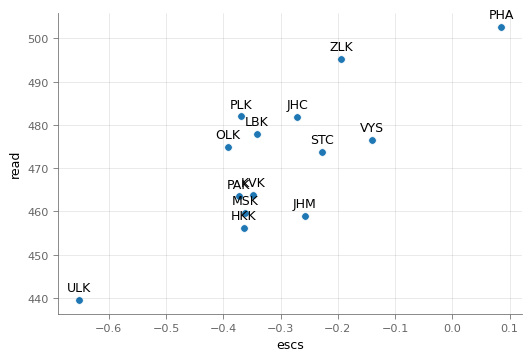

In [433]:
ax = sns.scatterplot(data=res, x='escs', y='read', label='reg')
for _, row in res.iterrows():
    ax.text(row['escs'], row['read'] + 2, row['reg'], ha='center')
ax.get_legend().remove()

In [411]:
df18__ = df18[(df18['gr'] == 9) & ~(df18['reg'].isnull())].copy()

In [412]:
df18__['reg'].value_counts(dropna=False)

MSK    312
PHA    301
STC    284
JHM    279
JHC    228
ZLK    220
ULK    217
LBK    184
VYS    179
OLK    166
PAK    154
HKK    139
PLK    138
KVK    104
Name: reg, dtype: int64

In [413]:
wm = lambda x: np.average(x, weights=df18__.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
np.round(df18__.groupby(['reg'], dropna=False)['read'].agg(wm))

reg
HKK    459.0
JHC    490.0
JHM    470.0
KVK    464.0
LBK    481.0
MSK    466.0
OLK    480.0
PAK    468.0
PHA    508.0
PLK    486.0
STC    481.0
ULK    460.0
VYS    477.0
ZLK    499.0
Name: read, dtype: float64

In [360]:
np.average(df18[['math', 'read', 'scie']], weights=df18['w'], axis=0)

array([499.46765091, 490.21881503, 496.79131066])

In [361]:
wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'])
df18.groupby('girl')[['math', 'read', 'scie']].agg(wm).reset_index()

girl        math        read        scie
0  False  501.186538  473.986385  495.994262
1   True  497.671595  507.180001  497.624143

In [367]:
wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
np.round(df18.groupby(['sch_type', 'sch_public'], dropna=False)['read'].agg(wm).unstack())

sch_public  False   True    NaN
sch_type                       
gym         558.0  601.0  580.0
gym4        561.0  580.0  597.0
sos         475.0  512.0  514.0
sou         391.0  412.0  377.0
spec          NaN  375.0  382.0
zs          410.0  459.0    NaN

In [372]:
wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
# ok, dropna is not working here due to pandas bug: https://github.com/pandas-dev/pandas/issues/36327
np.round(df18.groupby(['sch_type', 'sch_size'], dropna=False)['read'].agg(wm).unstack())

sch_size  (0.0, 250.0]  (250.0, 400.0]  (400.0, 550.0]  (550.0, inf]
sch_type                                                            
gym              550.0           587.0           604.0         617.0
gym4             562.0           576.0           584.0         581.0
sos              500.0           509.0           496.0         519.0
sou              412.0           415.0           400.0         419.0
spec             378.0             NaN             NaN           NaN
zs               426.0           454.0           463.0         473.0

In [281]:
df18[['read', 'w']].describe()

read            w
count  7019.000000  7019.000000
mean    506.855669    12.509984
std      97.247466     6.909633
min     175.222600     2.510990
25%     437.053450     6.722340
50%     513.105000    12.600950
75%     580.431400    14.767080
max     761.386200    77.803510

In [284]:
np.isfinite(df18[['read', 'w']]).sum()

read    7019
w       7019
dtype: int64

In [287]:
df18['sch_type'].value_counts()

zs      2347
gym     1527
sos     1342
sou      902
gym4     871
spec      30
Name: sch_type, dtype: int64

In [375]:
df18['sch_size'].value_counts(dropna=False)

(550.0, inf]      2672
(250.0, 400.0]    1682
(400.0, 550.0]    1516
(0.0, 250.0]       920
NaN                229
Name: sch_size, dtype: int64

In [374]:
df18['sch_size_wrong'] = df18['sch_size'].fillna(df18['sch_size'].cat.categories[3])

In [364]:
df18['sch_size_wrong'].value_counts(dropna=False)

(550.0, inf]      2901
(250.0, 400.0]    1682
(400.0, 550.0]    1516
(0.0, 250.0]       920
Name: sch_size_wrong, dtype: int64

In [365]:
wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
np.round(df18.groupby(['sch_type', 'sch_size'])['read'].agg(wm).unstack())

sch_size  (0.0, 250.0]  (250.0, 400.0]  (400.0, 550.0]  (550.0, inf]
sch_type                                                            
gym              550.0           587.0           604.0         617.0
gym4             562.0           576.0           584.0         581.0
sos              500.0           509.0           496.0         519.0
sou              412.0           415.0           400.0         419.0
spec             378.0             NaN             NaN           NaN
zs               426.0           454.0           463.0         473.0

In [328]:
wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
np.round(df18.groupby(['sch_type', 'sch_size_wrong'])['read'].agg(wm).unstack())

sch_size_wrong  (0.0, 250.0]  (250.0, 400.0]  (400.0, 550.0]  (550.0, inf]
sch_type                                                                  
gym                    550.0           587.0           604.0         612.0
gym4                   562.0           576.0           584.0         582.0
sos                    500.0           509.0           496.0         517.0
sou                    412.0           415.0           400.0         412.0
spec                   378.0             NaN             NaN           NaN
zs                     426.0           454.0           463.0         472.0

In [321]:
df18['sch_size'].cat.categories[3]

Interval(550.0, inf, closed='right')

In [313]:
df18['sch_size'].value_counts().sum()

6790

In [289]:
stu18[col_read].describe()

PV1READ      PV2READ      PV3READ      PV4READ      PV5READ  \
count  7019.000000  7019.000000  7019.000000  7019.000000  7019.000000   
mean    506.770372   507.437990   506.308270   506.984083   506.771309   
std      99.634496   100.485932   100.442517   101.015214   100.516336   
min     171.295000   168.764000   178.945000   162.986000   152.513000   
25%     435.800000   435.134500   433.828000   435.300000   435.644500   
50%     511.074000   512.035000   511.286000   511.379000   513.057000   
75%     581.551000   582.320000   581.817500   582.287000   580.744500   
max     799.351000   815.686000   850.737000   783.591000   785.869000   

           PV6READ      PV7READ      PV8READ      PV9READ     PV10READ  
count  7019.000000  7019.000000  7019.000000  7019.000000  7019.000000  
mean    506.901608   507.093579   506.943481   506.496750   506.849250  
std      99.883702   100.219447   100.620954   100.390044    99.841675  
min     182.461000   180.126000   138.540000   146.593000   164.569000  
25%     436.300000   435.109000   435.403500   435.378500   436.089000  
50%     512.540000   512.316000   511.100000   512.727000   512.216000  
75%     580.509000   580.881500   581.946000   579.919500   581.834000  
max     801.245000   822.127000   783.586000   800.576000   803.185000

In [290]:
stu18[col_read].isnull().values.any()

False

In [292]:
wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'])
#df18.groupby(['sch_type', 'sch_public'])[['math', 'read', 'scie']].agg(wm).reset_index()
np.round(df18.groupby(['sch_type', 'sch_public'])['read'].agg(wm).unstack())

sch_public  False   True
sch_type                
gym         564.0  601.0
gym4        569.0  580.0
sos         486.0  512.0
sou         382.0  412.0
spec        382.0  375.0
zs          410.0  459.0

In [293]:
df18['escs']

KeyError: 'escs'

In [247]:
df18.groupby(['sch_type', 'gr', 'sch_public'])['girl'].count().unstack().unstack()

sch_public False                     True                       
gr          7.0  8.0    9.0    10.0  7.0    8.0     9.0     10.0
sch_type                                                        
gym          NaN  1.0  120.0  100.0   NaN    2.0   598.0   706.0
gym4         NaN  NaN    NaN  127.0   NaN    NaN     NaN   744.0
sos          NaN  NaN    NaN  164.0   NaN    NaN     NaN  1178.0
sou          NaN  NaN    NaN   69.0   NaN    NaN     NaN   833.0
spec         NaN  NaN    NaN   11.0   1.0    3.0    15.0     NaN
zs           NaN  2.0   31.0    NaN  24.0  134.0  2156.0     NaN

In [161]:
to_drop = ['CZE9797', 'CZE2929', 'CZE3030', 'CZE3131', 'CZE3232']

df18 = df18[~df18['STRATUM'].isin(to_drop)].copy()
df18 = df18[df18[col_gg] == 9].copy()

In [166]:
np.average(df18[['math', 'read', 'scie']], weights=df18['w'], axis=0)

array([490.91368665, 479.19874075, 488.8390562 ])

In [164]:
df18.groupby('STRATUM')['w'].sum(), df18.groupby('STRATUM')['w'].sum().sum()

(STRATUM
 CZE0101    3168.15303
 CZE0202    4391.16153
 CZE0303    2056.64599
 CZE0404     939.90787
 CZE0505    3023.23574
 CZE0606    2956.23831
 CZE0707    2277.68982
 CZE0808    1872.95688
 CZE0909    2024.74184
 CZE1010    1824.35523
 CZE1111    3644.29990
 CZE1212    2236.31012
 CZE1313    3998.08639
 CZE1414    2715.20144
 CZE1515    1137.88023
 CZE1616     489.08568
 CZE1717     277.98220
 CZE1818     133.34249
 CZE1919     270.66194
 CZE2020     339.50191
 CZE2121     124.55356
 CZE2222     288.03789
 CZE2323     180.16063
 CZE2424     219.66434
 CZE2525     585.50405
 CZE2626     270.91623
 CZE2727     544.68554
 CZE2828     210.66423
 Name: w, dtype: float64,
 42201.62501)

In [149]:
df18.groupby('STRATUM')['w'].sum(), df18.groupby('STRATUM')['w'].sum().sum()

(STRATUM
 CZE0101    3373.30625
 CZE0202    4841.74520
 CZE0303    2160.23327
 CZE0404    1033.47336
 CZE0505    3856.19334
 CZE0606    3221.58908
 CZE0707    2315.16666
 CZE0808    1979.65019
 CZE0909    2185.58955
 CZE1010    1903.03589
 CZE1111    4035.92104
 CZE1212    2396.48308
 CZE1313    4284.29396
 CZE1414    2876.29012
 CZE1515    2345.34868
 CZE1616    1023.45706
 CZE1717     609.90761
 CZE1818     289.34080
 CZE1919     548.51354
 CZE2020     656.90681
 CZE2121     285.08932
 CZE2222     525.97724
 CZE2323     424.37849
 CZE2424     475.93928
 CZE2525    1309.45700
 CZE2626     647.46222
 CZE2727    1080.86056
 CZE2828     424.96075
 Name: w, dtype: float64,
 51110.57035)

In [167]:
# I should report also std errors, this is too crude!
wm = lambda x: np.average(x, weights=df18.loc[x.index, 'w'])
reg18 = df18.groupby('reg')[['math', 'read', 'scie']].agg(wm).reset_index()

In [168]:
reg18 = pd.merge(reg18, nuts3.rename(columns={'zkratka': 'reg'})[['reg', 'kod']])

In [169]:
reg18

reg        math        read        scie    kod
0   HKK  475.473199  459.325281  475.521384  CZ052
1   JHC  496.491914  490.067190  495.989650  CZ031
2   JHM  486.490097  470.160888  479.837643  CZ064
3   KVK  478.622746  463.528446  475.409183  CZ041
4   LBK  491.602915  480.840320  489.739230  CZ051
5   MSK  481.124150  466.263307  473.613122  CZ080
6   OLK  486.138178  480.239452  484.638763  CZ071
7   PAK  488.613151  467.636988  481.437391  CZ053
8   PHA  518.563724  508.356584  524.093673  CZ010
9   PLK  496.274538  486.383003  494.061152  CZ032
10  STC  487.480129  480.621144  489.875414  CZ020
11  ULK  473.077313  460.234503  466.382943  CZ042
12  VYS  486.123038  477.298540  484.348229  CZ063
13  ZLK  511.580623  498.665542  511.276139  CZ072

In [123]:
import folium
import geojson
import geopandas as gpd

In [95]:
with open('misc/kraje-simple.json') as f:
    geo_czechia = geojson.load(f)

In [143]:
gdf = gpd.read_file('misc/kraje-simple.json')

In [144]:
gdf = pd.merge(gdf, reg18.rename(columns={'kod': 'NUTS3_KOD'}))
gdf['math_trunc'] = np.round(gdf['math'], 1)
gdf['read_trunc'] = np.round(gdf['read'], 1)
gdf['scie_trunc'] = np.round(gdf['scie'], 1)

In [145]:
map0 = folium.Map(location=[49.8037633, 15.4749126], zoom_start=7, tiles='https://mapserver.mapy.cz/base-m/{z}-{x}-{y}', attr='<a href="https://www.mapy.cz" target="_blank">mapy.cz</a> attribution')

folium.Choropleth(geo_data=gdf, name='Choropleth', data=gdf, columns=['NUTS3_KOD', 'math'], key_on='feature.properties.NUTS3_KOD', fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.5, legend_name='Czechia').add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAZEV', 'math_trunc'],
        aliases=['Kraj', 'Matematika'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

#Add tooltip object to the map
map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

map0

In [146]:
map0 = folium.Map(location=[49.8037633, 15.4749126], zoom_start=7, tiles='https://mapserver.mapy.cz/base-m/{z}-{x}-{y}', attr='<a href="https://www.mapy.cz" target="_blank">mapy.cz</a> attribution')

folium.Choropleth(geo_data=gdf, name='Choropleth', data=gdf, columns=['NUTS3_KOD', 'read'], key_on='feature.properties.NUTS3_KOD', fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.5, legend_name='Czechia').add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAZEV', 'read_trunc'],
        aliases=['Kraj', 'Čtení'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

#Add tooltip object to the map
map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

map0

In [147]:
map0 = folium.Map(location=[49.8037633, 15.4749126], zoom_start=7, tiles='https://mapserver.mapy.cz/base-m/{z}-{x}-{y}', attr='<a href="https://www.mapy.cz" target="_blank">mapy.cz</a> attribution')

folium.Choropleth(geo_data=gdf, name='Choropleth', data=gdf, columns=['NUTS3_KOD', 'scie'], key_on='feature.properties.NUTS3_KOD', fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.5, legend_name='Czechia').add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    gdf,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAZEV', 'scie_trunc'],
        aliases=['Kraj', 'Přírodověda'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

#Add tooltip object to the map
map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

map0

In [72]:
df18.groupby('reg')[['math', 'read', 'scie', 'w']].apply(lambda x: np.average(x, weights=x['w'], axis=0))

TypeError: Series.name must be a hashable type

3        7
4       10
7       10
10      13
12       2
        ..
7007     6
7009     6
7015    13
7017     7
7018    13
Name: stratum_label, Length: 3874, dtype: int64

In [35]:
{k: v for k, v in stu18_meta.variable_value_labels['STRATUM'].items() if k.startswith('CZE')}

{'CZE1010': 'CZE - stratum 10: Basic/Region10',
 'CZE2020': 'CZE - stratum 20: 6-8yrGym/Region6',
 'CZE3030': 'CZE - stratum 30: Voc-Tech-Conservatory with maturate',
 'CZE0101': 'CZE - stratum 01: Basic/Region1',
 'CZE1111': 'CZE - stratum 11: Basic/Region11',
 'CZE2121': 'CZE - stratum 21: 6-8yrGym/Region7',
 'CZE3131': 'CZE - stratum 31: Voc-Tech Secondary without maturate',
 'CZE0202': 'CZE - stratum 02: Basic/Region2',
 'CZE1212': 'CZE - stratum 12: Basic/Region12',
 'CZE2222': 'CZE - stratum 22: 6-8yrGym/Region8',
 'CZE3232': 'CZE - stratum 32: Special & practical',
 'CZE0303': 'CZE - stratum 03: Basic/Region3',
 'CZE1313': 'CZE - stratum 13: Basic/Region13',
 'CZE2323': 'CZE - stratum 23: 6-8yrGym/Region9',
 'CZE0404': 'CZE - stratum 04: Basic/Region4',
 'CZE1414': 'CZE - stratum 14: Basic/Region14',
 'CZE2424': 'CZE - stratum 24: 6-8yrGym/Region10',
 'CZE0505': 'CZE - stratum 05: Basic/Region5',
 'CZE1515': 'CZE - stratum 15: 6-8yrGym/Region1',
 'CZE2525': 'CZE - stratum 25: 6-

In [55]:
int('1')

1

In [213]:
stu18_meta.variable_value_labels['ST004D01T']

{1.0: 'dívka',
 2.0: 'chlapec',
 5.0: 'Valid Skip',
 7.0: 'Not Applicable',
 8.0: 'Invalid',
 9.0: 'No Response'}